In [8]:
# import and set options
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import re
import utils

## Consistency

We measured the consistency of top-ranked predictions on two random splits of samples, which had the same propotion of samples from each cancer type. Ideally, driver gene predictions would be stable across the partitioning of the data. We use the TopDrop score to measure the fraction of genes at a designated depth that were consistently top-ranked. Methods with low TopDrop score may have too much variance in prediction, which may lead to false predictions.

In [10]:
def top_drop_overlap(s1, s2, depth):
    """Compute TopDrop overlap.
    
    Parameters
    ----------
    s1 : pd.Series
        p-values for first half of split
    s2 : pd.Series
        p-values for second half of split
    depth : int
        number of genes to examine consistency
    
    Returns
    -------
    ov_sim : float
        topdrop overlap score
    """
    # get gene of interest by specified depth
    s1, s2 = s1[:depth], s2[:2*depth]

    # genes are supposed to be the index of the series
    s1_genes = set(s1.index)
    s2_genes = set(s2.index)

    # calculate jaccard index
    num_intersect = len(s1_genes & s2_genes)
    num_total = len(s1_genes)
    if num_total:
        # provided series are not empty
        ov_sim = num_intersect / float(num_total)
    else:
        # empty series case
        ov_sim = 0
    return ov_sim

def consistency_comparison(df1, df2, mydepth,
                           method, config):
    """Computes the TopDrop consistency for results on two random splits 
    of samples.
    """
    # figure out which column to use
    if utils.is_valid_config(config, method, 'consistency'):
        pval_cols = config[method]['consistency']
    else:
        pval_cols = ['pvalue']

    # check to see if the columns exist
    all_exist = all([p in df1.columns for p in pval_cols])
    if not all_exist:
        print('Not all p-value columns were named correctly. Please specify '
              'correct name in config file.')
        return None

    results = pd.DataFrame(index=[method])

    pval1 = df1[pval_cols].min(axis=1).copy()
    pval2 = df2[pval_cols].min(axis=1).copy()
    pval1.sort_values(ascending=True, inplace=True)
    pval2.sort_values(ascending=True, inplace=True)

    # add top-drop scores
    top_drop = top_drop_overlap(pval1, pval2, depth=mydepth)
    td_scores = [top_drop]

    tmp_results = pd.DataFrame({
        'TopDrop {0} overlap'.format(mydepth): td_scores
    },
    index=[method])
    results = pd.concat([results, tmp_results], axis=1)

    return results

def calculate_stats(df):
    """Computes mean and sem of topdrop.
    
    Parameters
    ----------
    df : pd.DataFrame
        data frame containing topdrop scores
    
    Returns
    -------
    result_df : pd.DataFrame
        Data frame with mean and sem
    """
    tmp_means = df.mean()
    tmp_sem = df.sem()
    name = df.columns[0]
    result_df = pd.DataFrame({name+' mean': tmp_means,
                              name+' sem': tmp_sem})
    result_df.rename(index=lambda x: df.index[0], inplace=True)
    return result_df

def read_consistency_results(consis_dir, depth, config):
    """Read in the consistency result files."""
    # read in results
    sim_results = {}
    # iterate over random splits
    for i, mydir in enumerate(os.listdir(consis_dir)):
        # figure out the methods
        iter_dir = os.path.join(consis_dir, mydir)
        methods = set(map(lambda x: re.split( '_[12]', os.path.basename(x))[0],
                          os.listdir(iter_dir)))

        # iterate over methods
        for method in methods:
            # prepare path
            first_outfix = '{prefix}_1.txt'.format(prefix=method)
            second_outfix = '{prefix}_2.txt'.format(prefix=method)
            first_path = os.path.join(iter_dir, first_outfix)
            second_path = os.path.join(iter_dir, second_outfix)

            # read data
            first_df = pd.read_csv(first_path, sep='\t', index_col=0)
            second_df = pd.read_csv(second_path, sep='\t', index_col=0)

            # calculate consistency
            consistency_df = consistency_comparison(first_df, second_df,
                                                    depth,
                                                    method,
                                                    config)
            sim_results.setdefault(method, [])
            sim_results[method].append(consistency_df)

    # concatenate each iteration into dataframe
    for method in sim_results:
        sim_results[method] = pd.concat(sim_results[method])

    # record result
    final_results = []
    for method in sim_results:
        tmp_results = calculate_stats(sim_results[method])
        final_results.append(tmp_results)
    final_df = pd.concat(final_results)
    
    return final_df

### Compute the TopDrop overlap

The TopDrop consistency scores are directly computed from result files found in the `example_data/consistency_output` file.

In [31]:
# read in config file
config = utils.load_config('config.yaml')

# read in and calculate TopDrop consistency
result = read_consistency_results('example_data/consistency_data/',  # directory for result files
                                  100,  # TopDrop 100
                                  config)
result

,TopDrop 100 overlap mean,TopDrop 100 overlap sem
ActiveDriver,0.190,0.008165
OncodriveClust,0.232,0.005538
TUSON,0.727,0.009551
OncodriveFML,0.514,0.010242
MuSiC,0.869,0.008090
MutsigCV,0.505,0.006009
OncodriveFM,0.506,0.011274
2020+,0.749,0.010796


### Consistency plot

The following function creates a bar plot for the consistency results stored in the above data frame.

In [35]:
def plot_consistency(consis_df, depth, custom_order=None):
    """Plot the consistency results."""
    # get col names and format order
    mean_col = 'TopDrop {0} overlap mean'.format(depth)
    sem_col = 'TopDrop {0} overlap sem'.format(depth)
    
    # figure out order of bar plot
    if custom_order is None:
        custom_order = consis_df.sort_values(mean_col).index.tolist()

    # make plot
    with sns.axes_style('ticks'), sns.plotting_context('talk', font_scale=1.5):
            myax = sns.barplot(custom_order, consis_df[mean_col].ix[custom_order],
                               order=custom_order, color=sns.xkcd_rgb["grey"])
            myax.errorbar(np.arange(len(custom_order)), consis_df[mean_col].ix[custom_order],
                          yerr=consis_df[sem_col].ix[custom_order],
                          fmt=None, ecolor=sns.xkcd_rgb["black"],
                          elinewidth=2, capsize=9, capthick=2)
            myax.set_xticklabels(custom_order, rotation=45, ha='right')
            myax.yaxis.set_ticks_position('left')
            myax.xaxis.set_ticks_position('bottom')
            myax.set_ylabel('TopDrop Consistency ({0})'.format(depth))
            myax.set_ylim((0, 1.0))

            sns.despine()
            ax = plt.gca()
            plt.gca().tick_params(axis='x', which='major', pad=0)
            plt.title('Consistency')

    # save output
    plt.gcf().set_size_inches(7, 7)
    plt.tight_layout()

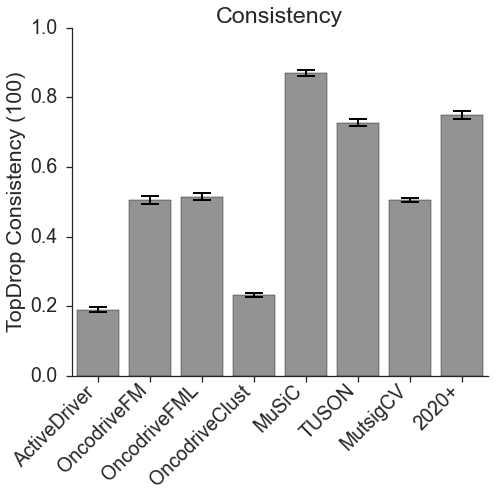

In [36]:
# make bar plot for consistency
order = ['ActiveDriver', 'OncodriveFM', 'OncodriveFML', 
         'OncodriveClust', 'MuSiC', 'TUSON', 'MutsigCV', '2020+']
plot_consistency(result, 100, custom_order=order)